# 2 (30 puntos) Perceptrón multi-capa para detección de glaucoma en imágenes de fondo de ojo

1. Modifique el perceptrón multi-capa y la red convolucional implementadas en el codigo base provisto. Explique las modificaciones necesarias para implementar que ambos modelos funcionen para el objetivo especificado.

## Imports

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch import nn, optim
from matplotlib import cm
from matplotlib import style
from locale import normalize
from matplotlib.pyplot import imshow

%matplotlib widget
style.use('default')

## Parámetros

In [20]:
lr = 0.01 # Learning rate empleado para la función de optimización SGD
epochs = 15 # Cantidad de iteraciones que se ejecutaran por cada intento
attempts = 10 # Cantidad de intentos totales que se ejecutaran (en cada uno de los cuales se creará el modelo, entrenará y obtendrán datos de efectividad)
img_size = 227 # Tamaño asignado para el width y height de las imágenes para entrenar y probar.
batch_size = 32 # Cantidad de imágenes que serán procesadas por lote.
criterion = nn.NLLLoss() # Función de perdida que se calculará individualmente para cada iteración y que se suma al total del intento
ruta_base = r'.\\DatosDePrueba\\' # Ruta de la computadora a partir de la cual se accede a los datos de prueba
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Dispositivo en el que se ejecutará
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((img_size, img_size))]) # Transformaciones aplicadas a los sets de entrenamiento y pruebas (todas las imágenes se ajustan al cuadrado img_size)

## Cargado de datos de entrenamiento y prueba

[Batch_size, channels, img_size, img_size] =, torch.Size([32, 3, 227, 227])


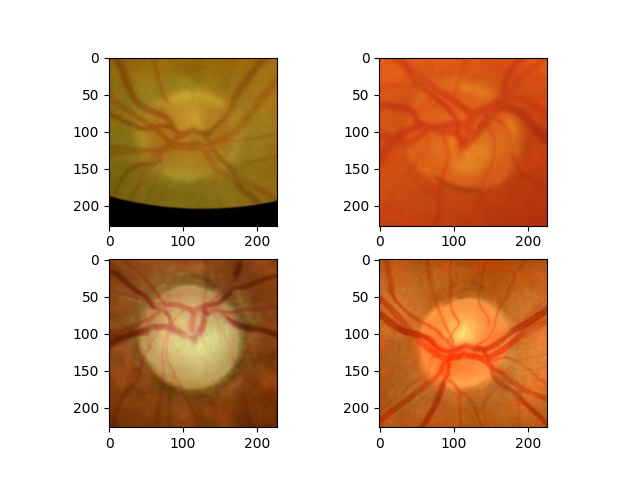

In [21]:
def load_data(nom_carpeta): # Carga imágenes desde el folder según el nombre que se indique
    set = torchvision.datasets.ImageFolder(ruta_base + nom_carpeta, transform = transform)
    loader = torch.utils.data.DataLoader(set, batch_size = batch_size, shuffle = True)
    return loader

def load_test_train_data(): # Carga imágenes de entrenamiento y pruebas
    trainloader = load_data('train')
    testloader = load_data('test')
    return trainloader, testloader
    
trainloader, testloader = load_test_train_data()
dataiter = iter(trainloader)
images, labels = dataiter.next()


print('[Batch_size, channels, img_size, img_size] =,', images.mT.shape)

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(images[0].T.numpy().squeeze(), cmap='gray_r')
axs[0,1].imshow(images[1].T.numpy().squeeze(), cmap='gray_r')
axs[1,0].imshow(images[2].T.numpy().squeeze(), cmap='gray_r')
axs[1,1].imshow(images[3].T.numpy().squeeze(), cmap='gray_r')

## Creando el modelo del perceptrón multicapa

In [22]:
def create_MLP_model(verbose = True): # Creación del modelo
  model = nn.Sequential(
    nn.Linear(img_size*img_size*3,128), # Empleando como entrada las dimensiones de la imagen (w * h) multiplicado por los 3 canales de color que se están utilizando => 154587 = 227 * 227 * 3
    nn.Sigmoid(),
    nn.Linear(128,64),
    nn.Sigmoid(),
    nn.Linear(64,2),
    nn.LogSoftmax(dim=1))
  
  if (verbose): print("Running on device: ", device)
  model.to(device)
  return model

mlp_model = create_MLP_model()
print("MLP model")
print(mlp_model)

Running on device:  cuda
MLP model
Sequential(
  (0): Linear(in_features=154587, out_features=128, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax(dim=1)
)


## Entrenando el modelo

In [23]:
def train_model(model, criterion, epochs, lr, verbose = True):
    start = time()
    epochs_list = []
    running_loss_list= []
    optimizer = optim.SGD(model.parameters(), lr= lr, momentum=0.9)

    for e in range(epochs):
        running_loss = 0
        
        for images, labels in trainloader: # Ejecución de la iteración por lotes
            images = images.to(device) # Se preparan las imágenes del lote en el device usado
            labels = labels.to(device)            
            images = images.view(images.shape[0], -1) 
            
            optimizer.zero_grad()
            output = model(images) # Aplicando el modelo para cada batch
            loss = criterion(output, labels) # Y calculando el error asociado
            loss.backward() # Aprendizaje por backpropagation
            optimizer.step() # weights optimization
            running_loss += loss.item() # Se suma la pérdida para el total de la iteración

        else:
            if (verbose): print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

    if (verbose): print("\nTraining Time (in minutes) =",(time()-start)/60)
    return model

print("Training MLP model")
print("Device", next(mlp_model.parameters()).is_cuda)

mlp_model = train_model(mlp_model, criterion, epochs, lr)

Training MLP model
Device True
Epoch 0 - Training loss: 0.6992378234863281
Epoch 1 - Training loss: 0.7098370306193829
Epoch 2 - Training loss: 0.6827036216855049
Epoch 3 - Training loss: 0.670877680182457
Epoch 4 - Training loss: 0.6443322114646435
Epoch 5 - Training loss: 0.5978217907249928
Epoch 6 - Training loss: 0.5601713452488184
Epoch 7 - Training loss: 0.4904858861118555
Epoch 8 - Training loss: 0.4233626704663038
Epoch 9 - Training loss: 0.39005396515130997
Epoch 10 - Training loss: 0.42049169167876244
Epoch 11 - Training loss: 0.35954951122403145
Epoch 12 - Training loss: 0.34391774982213974
Epoch 13 - Training loss: 0.3659131433814764
Epoch 14 - Training loss: 0.313126583583653

Training Time (in minutes) = 0.5995783050855


## Probando el modelo

In [27]:
def test_model_mlp(testloader, model, verbose = True):
    correct_rate, false_negative_rate, all_count = 0, 0, 0
    
    for images,labels in testloader:
      images = images.to(device)  # Se preparan las imágenes del lote en el device usado
      labels = labels.to(device)

      for i in range(len(labels)): # se itera sobre los índices de targets
        img = images[i].view(1, img_size*img_size*3)
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        pred_label = probab.index(max(probab)) # Se obtiene el target predicho de la iteración actual
        true_label = labels.cpu().numpy()[i] # Se obtiene el target correcto de la iteración actual
        
        if (true_label == pred_label): correct_rate += 1 # Predicción correcta si igual a target
        else:
          if (pred_label == 0): false_negative_rate += 1 # Falso negativo si predicción es 0 pero correcto 1

        all_count += 1

    if (verbose):
      print("Images Tested =", all_count)
      print("Correct Tests =", correct_rate)
      print("False Positive Tests =", (all_count - correct_rate) - false_negative_rate)
      print("False Negative Tests =", false_negative_rate)
      print("\nModel Accuracy =", (correct_rate/all_count))

    return correct_rate, false_negative_rate, all_count

print("Testing MLP model")
res = test_model_mlp(testloader, mlp_model)

Testing MLP model
Images Tested = 210
Correct Tests = 186
False Positive Tests = 6
False Negative Tests = 18

Model Accuracy = 0.8857142857142857


## Ejecuciones consecutivas de entrenamiento y pruebas

a) Entrene el perceptrón multi-capa usando el conjunto de datos completo para entrenamiento y validación. Calibre los hiper-parámetros necesarios para obtener los mejores resultados posibles y reportelos. Ejecute el entrenamiento 10 veces por 15 épocas por corrida, y reporte la tasa de aciertos tasa de aciertos, falsos positivos y falsos negativos promedio y su desviación estándar para esas 10 corridas.

In [30]:
print('{} training and testing attempts:\n'.format(attempts))
aciertos = []

for i in range(attempts):
    mlp_model = create_MLP_model(False)
    mlp_model = train_model(mlp_model, criterion, epochs, lr, False)
    correct_rate, false_negative_rate, all_count = test_model_mlp(testloader, mlp_model, False)
    aciertos.append(correct_rate)

    print('Results of attempt #{}:'.format(i))
    print('\tCorrect: {}\tFalse Positive Tests: {}\tFalse Negative Tests: {}\tModel Accuracy: {}\n'.format(correct_rate, (all_count - correct_rate) - false_negative_rate, false_negative_rate, correct_rate/all_count))

resultados = torch.tensor(aciertos)
print('Average correct tests: {}'.format(torch.mean(resultados.double()).item()))
print('Standard deviation: {}\n'.format(torch.std(resultados.double()).item()))

10 training and testing attempts:

Results of attempt #0:
	Correct: 189	False Positive Tests: 13	False Negative Tests: 8	Model Accuracy: 0.9

Results of attempt #1:
	Correct: 180	False Positive Tests: 25	False Negative Tests: 5	Model Accuracy: 0.8571428571428571

Results of attempt #2:
	Correct: 187	False Positive Tests: 15	False Negative Tests: 8	Model Accuracy: 0.8904761904761904

Results of attempt #3:
	Correct: 187	False Positive Tests: 4	False Negative Tests: 19	Model Accuracy: 0.8904761904761904

Results of attempt #4:
	Correct: 165	False Positive Tests: 42	False Negative Tests: 3	Model Accuracy: 0.7857142857142857

Results of attempt #5:
	Correct: 180	False Positive Tests: 24	False Negative Tests: 6	Model Accuracy: 0.8571428571428571

Results of attempt #6:
	Correct: 185	False Positive Tests: 11	False Negative Tests: 14	Model Accuracy: 0.8809523809523809

Results of attempt #7:
	Correct: 161	False Positive Tests: 46	False Negative Tests: 3	Model Accuracy: 0.7666666666666667

Res